

- 모델 (은닉층 1개만)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.utils import to_categorical #원 핫 인코딩

from tensorflow.keras.applications import Xception, ResNet50, InceptionV3, MobileNet
from tensorflow.keras.callbacks import EarlyStopping

import shutil
import os
import cv2

from datetime import datetime

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
dataset_path = '/content/gdrive/MyDrive/Colab Notebooks/data'
shutil.copy(os.path.join(dataset_path, '0118food.zip'), '/content')

'/content/0118food.zip'

- food
  - train
    - burger
    - chicken
    - pasta
    - pizza
    - porkcutlet
    - sushi
    - tteokbokki
  - test
    - ..

In [7]:
# 꼭대기 폴더 'food' 안에 각 폴더+정답이름이미지폴더 만들어서 진행할 것

DATA_ROOT_DIR = os.path.join('/content', 'food') #꼭대기 폴더 지정
TRAIN_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'train')
TEST_DATA_ROOT_DIR = os.path.join(DATA_ROOT_DIR, 'test')

In [8]:
### food.zip 압축풀기
import zipfile
with zipfile.ZipFile(os.path.join('/content', '0118food.zip'), 'r') as target_file:
    target_file.extractall(TRAIN_DATA_ROOT_DIR)

In [9]:
# test폴더 - Pasta,Burger, ... 폴더 생성
os.mkdir(TEST_DATA_ROOT_DIR)
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'pasta'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'burger'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'chicken'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'sushi'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'pizza'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'porkcutlet'))
os.mkdir(os.path.join(TEST_DATA_ROOT_DIR, 'tteokbokki'))

In [10]:
import glob
ratio = 0.2

src_root_dir = "/content/food/train/"
dst_root_dir = "/content/food/test/"

label_name_list = os.listdir(TRAIN_DATA_ROOT_DIR)
for label_name in label_name_list:
    train_image_file_list = glob.glob(src_root_dir + label_name + "/*.*")
    print("==========================================================")
    
    print("total [%s] image file nums => [%s]"%(label_name, len(train_image_file_list)))
    
    split_num = int(ratio * len(train_image_file_list))
    print("분리할 갯수 : ", split_num)
    
    test_image_file_list = train_image_file_list[0:split_num]
    
    # move
    move_nums = 0
    for image_file in test_image_file_list:
        shutil.move(image_file, dst_root_dir + label_name)
        move_nums = move_nums + 1
        
    print("total move nums => ", move_nums)
    print("===========================================================")

total [sushi] image file nums => [3650]
분리할 갯수 :  730
total move nums =>  730
total [pasta] image file nums => [3562]
분리할 갯수 :  712
total move nums =>  712
total [chicken] image file nums => [3580]
분리할 갯수 :  716
total move nums =>  716
total [burger] image file nums => [4024]
분리할 갯수 :  804
total move nums =>  804
total [porkcutlet] image file nums => [4756]
분리할 갯수 :  951
total move nums =>  951
total [tteokbokki] image file nums => [3695]
분리할 갯수 :  739
total move nums =>  739
total [pizza] image file nums => [4814]
분리할 갯수 :  962
total move nums =>  962


In [11]:
label_name_list

['sushi', 'pasta', 'chicken', 'burger', 'porkcutlet', 'tteokbokki', 'pizza']

## 훈련용 데이터

In [12]:
import cv2

train_data_list = []
train_label_list = [] #정답

class_dict = {'burger':0, 'chicken':1, 'pasta':2, 'pizza':3, 'porkcutlet':4, 'sushi':5, 'tteokbokki':6}

start_time = datetime.now()
for label_name in label_name_list:
  file_path = os.path.join(TRAIN_DATA_ROOT_DIR, label_name)
  img_file_list = glob.glob(file_path + '/*.*') #여기서 읽어온 것 아니고 읽어올 리스트만 가져온 것

  for img in img_file_list:
    src_img = cv2.imread(img, cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(128, 128)) #사진크기
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    train_data_list.append(src_img)
    train_label_list.append(class_dict[label_name]) #정답(문자-> 0, 1로 바꿔주기; dict[key값]으로 0, 1 가져오기. 간단하게 이렇게 할수도)
end_time = datetime.now()
print('Elapsed Time : ', end_time-start_time)

Elapsed Time :  0:00:42.116361


In [13]:
X_train = np.array(train_data_list).astype('float32')
y_train = np.array(train_label_list).astype('float32')

print(X_train.shape, y_train.shape)

(22467, 128, 128, 3) (22467,)


## 테스트용 데이터

In [14]:
test_data_list = []
test_label_list = [] #정답

for label_name in label_name_list:
  file_path = os.path.join(TEST_DATA_ROOT_DIR, label_name)
  img_file_list = glob.glob(file_path + '/*.*') #여기서 읽어온 것 아니고 읽어올 리스트만 가져온 것

  for img in img_file_list:
    src_img = cv2.imread(img, cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(128, 128)) 
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    test_data_list.append(src_img)
    test_label_list.append(class_dict[label_name])

In [15]:
X_test = np.array(test_data_list).astype('float32')
y_test = np.array(test_label_list).astype('float32')

print(X_test.shape, y_test.shape)

(5614, 128, 128, 3) (5614,)


In [16]:
len(os.listdir(TRAIN_DATA_ROOT_DIR))

7

In [17]:
# 정규화
X_train = X_train / 255.0
X_test = X_test / 255.0

## 전이학습

In [18]:
# 모바일넷
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128

base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3))
base_model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32) 

In [19]:
class_nums = len(os.listdir(TRAIN_DATA_ROOT_DIR)) #정답 개수
print(class_nums)

7


In [20]:
model = Sequential()

model.add(base_model)
model.add(GlobalAveragePooling2D())


model.add(Dense(64, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.25))



model.add(Dense(class_nums, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_128 (Functio  (None, 4, 4, 1024)       3228864   
 nal)                                                            
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 64)                65600     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 7)                 455       
                                                                 
Total params: 3,294,919
Trainable params: 3,273,031
Non-

In [21]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [22]:
from datetime import datetime
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


# earlystopping = EarlyStopping(monitor='val_loss',  # 모니터 기준 설정 (val loss) 
#                               patience=5,          # 5회 Epoch동안 개선되지 않는다면 종료
#                              )


start_time = datetime.now()

hist = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=128) #callbacks=[earlystopping]

end_time = datetime.now()
print('elapsed time = ', end_time-start_time)

Epoch 1/50
176/176 [==============================] - 54s 238ms/step - loss: 1.0685 - accuracy: 0.6598 - val_loss: 6.5322 - val_accuracy: 0.2918
Epoch 2/50
176/176 [==============================] - 40s 225ms/step - loss: 0.6454 - accuracy: 0.8001 - val_loss: 1.2997 - val_accuracy: 0.7305
Epoch 3/50
176/176 [==============================] - 40s 228ms/step - loss: 0.4922 - accuracy: 0.8555 - val_loss: 2.3927 - val_accuracy: 0.5078
Epoch 4/50
176/176 [==============================] - 40s 229ms/step - loss: 0.4303 - accuracy: 0.8750 - val_loss: 5.3287 - val_accuracy: 0.3894
Epoch 5/50
176/176 [==============================] - 41s 230ms/step - loss: 0.3822 - accuracy: 0.8897 - val_loss: 1.9999 - val_accuracy: 0.6338
Epoch 6/50
176/176 [==============================] - 41s 232ms/step - loss: 0.3400 - accuracy: 0.9006 - val_loss: 1.7621 - val_accuracy: 0.7171
Epoch 7/50
176/176 [==============================] - 40s 230ms/step - loss: 0.3124 - accuracy: 0.9112 - val_loss: 1.3560 - val_ac

In [ ]:
# 0.9881 / 0.9478 :  (food.zip/yespizza.h5) epochs=50, batch_size=128, learning_rate=0.00001
# 0.9927 / 0.9526 :  (0118food.zip) 은닉층 2개(64, 128) epochs=50, batch_size=128, learning_rate=0.00001
# 0.9848 / 0.7852 :  (0118food.zip) 은닉층 1개(64) epochs=50, batch_size=128, learning_rate=0.01


In [23]:
model.save('finalfood_hidden1.h5')

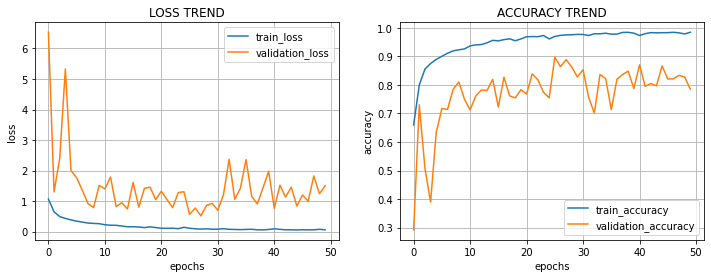

In [24]:
plt.figure(figsize=(12,4))

plt.subplot(1, 2, 1)
plt.title("LOSS TREND")
plt.xlabel("epochs")
plt.ylabel('loss')
plt.grid()

plt.plot(hist.history['loss'], label='train_loss')
plt.plot(hist.history['val_loss'], label='validation_loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.title("ACCURACY TREND")
plt.xlabel("epochs")
plt.ylabel('accuracy')
plt.grid()

plt.plot(hist.history['accuracy'], label='train_accuracy')
plt.plot(hist.history['val_accuracy'], label='validation_accuracy')
plt.legend(loc='best')

## predict1

In [30]:
# 이미지 불러오기, 색상변환, 크기조정, 정규화
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
pred_img_list = []
pred_img_name_list = glob.glob('./predict/*.*')
for i in range(len(pred_img_name_list)):
    src_img = cv2.imread(pred_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    src_img = src_img / 255.0
    pred_img_list.append(src_img)
len(pred_img_list)

36

In [31]:
pred_img_array = np.array(pred_img_list) #3차원 한번더 묶어서 4차원으로 차원 맞추기
pred_img_array.shape

(36, 128, 128, 3)

In [32]:
pred = model.predict(pred_img_array)

2/2 [==============================] - 1s 173ms/step


In [33]:
# {'burger':0, 'chicken':1, 'pasta':2, 'pizza':3, 'porkcutlet':4, 'sushi':5, 'tteokbokki':6}

class_name = ['burger', 'chicken', 'pasta', 'pizza', 'porkcutlet', 'sushi', 'tteokbokki']
for i in range(len(pred)):
    class_index = np.argmax(pred[i])
    print(str(i+1) + '번째 : ' + class_name[class_index], pred[i].max())

1번째 : pizza 1.0
2번째 : pasta 0.9886437
3번째 : porkcutlet 0.99998486
4번째 : pizza 0.9999999
5번째 : pasta 1.0
6번째 : tteokbokki 0.9999981
7번째 : pizza 0.9995796
8번째 : sushi 1.0
9번째 : pizza 0.60247046
10번째 : pasta 1.0
11번째 : sushi 0.99999404
12번째 : pasta 0.95724326
13번째 : pasta 0.9990097
14번째 : pasta 1.0
15번째 : sushi 0.99999
16번째 : pizza 0.99999475
17번째 : pasta 0.97787935
18번째 : porkcutlet 0.898546
19번째 : pasta 1.0
20번째 : pasta 1.0
21번째 : pasta 1.0
22번째 : pasta 0.9999864
23번째 : pizza 0.9974746
24번째 : pasta 1.0
25번째 : pizza 0.9999535
26번째 : pasta 0.99992895
27번째 : pasta 0.8614663
28번째 : pasta 0.98801696
29번째 : sushi 1.0
30번째 : pasta 1.0
31번째 : pizza 0.9531933
32번째 : pasta 1.0
33번째 : pasta 0.99876416
34번째 : sushi 0.9999999
35번째 : chicken 0.9958626
36번째 : pasta 0.9891651


In [34]:
# 상위 3개 예측값
top3 = 3
for i in range(len(pred)):
    sorted_index = pred[i].argsort()
    sorted_index = sorted_index[::-1]
    print("===================================")
    print(str(i+1) + '번째')
    print(sorted_index)
    for j in range(top3):
        pred_val = pred[i, sorted_index[j]]
        class_index = sorted_index[j]
        print("예측값 : ", class_name[class_index], pred_val)

1번째
[3 5 2 6 4 1 0]
예측값 :  pizza 1.0
예측값 :  sushi 9.858843e-10
예측값 :  pasta 2.3432398e-10
2번째
[2 6 0 3 1 4 5]
예측값 :  pasta 0.9886437
예측값 :  tteokbokki 0.011294628
예측값 :  burger 2.4592626e-05
3번째
[4 6 1 2 5 3 0]
예측값 :  porkcutlet 0.99998486
예측값 :  tteokbokki 9.134844e-06
예측값 :  chicken 4.316007e-06
4번째
[3 5 2 6 1 4 0]
예측값 :  pizza 0.9999999
예측값 :  sushi 1.723024e-07
예측값 :  pasta 5.3457182e-08
5번째
[2 3 6 4 1 5 0]
예측값 :  pasta 1.0
예측값 :  pizza 7.461004e-10
예측값 :  tteokbokki 9.703242e-13
6번째
[6 1 2 0 4 5 3]
예측값 :  tteokbokki 0.9999981
예측값 :  chicken 1.7819123e-06
예측값 :  pasta 1.0431532e-07
7번째
[3 2 5 6 1 4 0]
예측값 :  pizza 0.9995796
예측값 :  pasta 0.00031824637
예측값 :  sushi 0.000101893485
8번째
[5 0 2 1 3 4 6]
예측값 :  sushi 1.0
예측값 :  burger 5.6250543e-14
예측값 :  pasta 8.496867e-16
9번째
[3 2 5 1 0 6 4]
예측값 :  pizza 0.60247046
예측값 :  pasta 0.39679736
예측값 :  sushi 0.0007102649
10번째
[2 3 6 4 1 5 0]
예측값 :  pasta 1.0
예측값 :  pizza 8.542697e-15
예측값 :  tteokbokki 1.6725954e-17
11번째
[5 0 2 3 1 4 6]
예측값 :  

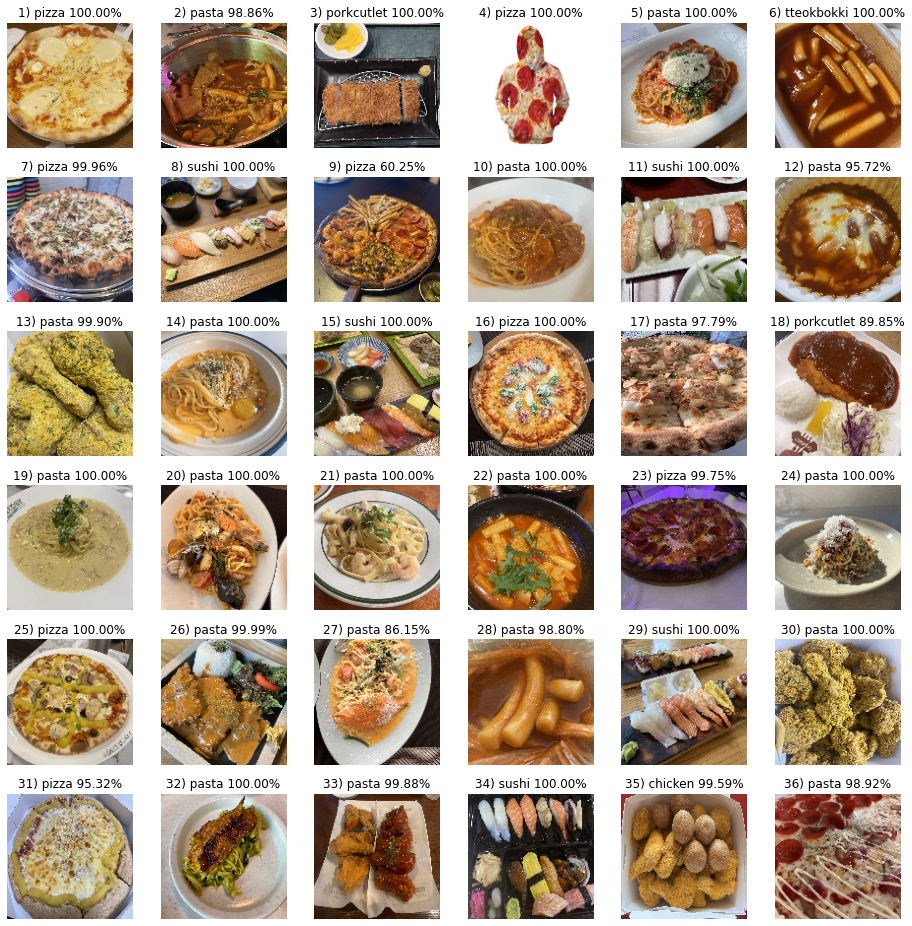

In [35]:
plt.figure(figsize=(13,13))

for i in range(len(pred)):
    plt.subplot(round(len(pred)/6), 6, i+1)
    class_index = np.argmax(pred[i])
    strTitle = str('{0:0.2f}'.format(100*max(pred[i]))) + '%'
    plt.title(str(i+1) + ') ' + class_name[class_index] + ' ' + strTitle) 
    plt.imshow(pred_img_list[i])
    plt.axis('off')
plt.tight_layout()

## predict2

In [36]:
# 이미지 불러오기, 색상변환, 크기조정, 정규화
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
pred_img_list = []
pred_img_name_list = glob.glob('./predict2/*.*')
for i in range(len(pred_img_name_list)):
    src_img = cv2.imread(pred_img_name_list[i], cv2.IMREAD_COLOR)
    src_img = cv2.resize(src_img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH))
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)
    src_img = src_img / 255.0
    pred_img_list.append(src_img)
len(pred_img_list)

36

In [37]:
pred_img_array = np.array(pred_img_list) #3차원 한번더 묶어서 4차원으로 차원 맞추기
pred_img_array.shape

(36, 128, 128, 3)

In [38]:
pred = model.predict(pred_img_array)

2/2 [==============================] - 0s 15ms/step


In [39]:
# {'burger':0, 'chicken':1, 'pasta':2, 'pizza':3, 'porkcutlet':4, 'sushi':5, 'tteokbokki':6}

class_name = ['burger', 'chicken', 'pasta', 'pizza', 'porkcutlet', 'sushi', 'tteokbokki']
for i in range(len(pred)):
    class_index = np.argmax(pred[i])
    print(str(i+1) + '번째 : ' + class_name[class_index], pred[i].max())

1번째 : pizza 1.0
2번째 : pasta 0.9886437
3번째 : porkcutlet 0.99998486
4번째 : pasta 1.0
5번째 : tteokbokki 0.9999981
6번째 : pizza 0.9995796
7번째 : sushi 1.0
8번째 : pizza 0.60247046
9번째 : pasta 1.0
10번째 : sushi 0.99999404
11번째 : pasta 0.95724326
12번째 : pasta 0.9990097
13번째 : pasta 1.0
14번째 : sushi 0.99999
15번째 : pizza 0.99999475
16번째 : pasta 0.97787935
17번째 : porkcutlet 0.898546
18번째 : pasta 1.0
19번째 : pasta 1.0
20번째 : pasta 1.0
21번째 : pasta 1.0
22번째 : pasta 0.9999864
23번째 : pizza 0.9974746
24번째 : pasta 1.0
25번째 : pizza 0.9999535
26번째 : pasta 0.99992895
27번째 : pasta 0.8614663
28번째 : sushi 1.0
29번째 : pasta 1.0
30번째 : pizza 0.9531933
31번째 : pasta 1.0
32번째 : pasta 0.99876416
33번째 : porkcutlet 0.45139372
34번째 : sushi 0.9999999
35번째 : chicken 0.9958626
36번째 : pasta 0.9891651


In [40]:
# 상위 3개 예측값
top3 = 3
for i in range(len(pred)):
    sorted_index = pred[i].argsort()
    sorted_index = sorted_index[::-1]
    print("===================================")
    print(str(i+1) + '번째')
    print(sorted_index)
    for j in range(top3):
        pred_val = pred[i, sorted_index[j]]
        class_index = sorted_index[j]
        print("예측값 : ", class_name[class_index], pred_val)

1번째
[3 5 2 6 4 1 0]
예측값 :  pizza 1.0
예측값 :  sushi 9.858843e-10
예측값 :  pasta 2.3432398e-10
2번째
[2 6 0 3 1 4 5]
예측값 :  pasta 0.9886437
예측값 :  tteokbokki 0.011294628
예측값 :  burger 2.4592626e-05
3번째
[4 6 1 2 5 3 0]
예측값 :  porkcutlet 0.99998486
예측값 :  tteokbokki 9.134844e-06
예측값 :  chicken 4.316007e-06
4번째
[2 3 6 4 1 5 0]
예측값 :  pasta 1.0
예측값 :  pizza 7.461004e-10
예측값 :  tteokbokki 9.703242e-13
5번째
[6 1 2 0 4 5 3]
예측값 :  tteokbokki 0.9999981
예측값 :  chicken 1.7819123e-06
예측값 :  pasta 1.0431532e-07
6번째
[3 2 5 6 1 4 0]
예측값 :  pizza 0.9995796
예측값 :  pasta 0.00031824637
예측값 :  sushi 0.000101893485
7번째
[5 0 2 1 3 4 6]
예측값 :  sushi 1.0
예측값 :  burger 5.6250543e-14
예측값 :  pasta 8.496867e-16
8번째
[3 2 5 1 0 6 4]
예측값 :  pizza 0.60247046
예측값 :  pasta 0.39679736
예측값 :  sushi 0.0007102649
9번째
[2 3 6 4 1 5 0]
예측값 :  pasta 1.0
예측값 :  pizza 8.542697e-15
예측값 :  tteokbokki 1.6725954e-17
10번째
[5 0 2 3 1 4 6]
예측값 :  sushi 0.99999404
예측값 :  burger 3.475905e-06
예측값 :  pasta 1.5359545e-06
11번째
[2 6 1 0 4 3 5]
예측값 :

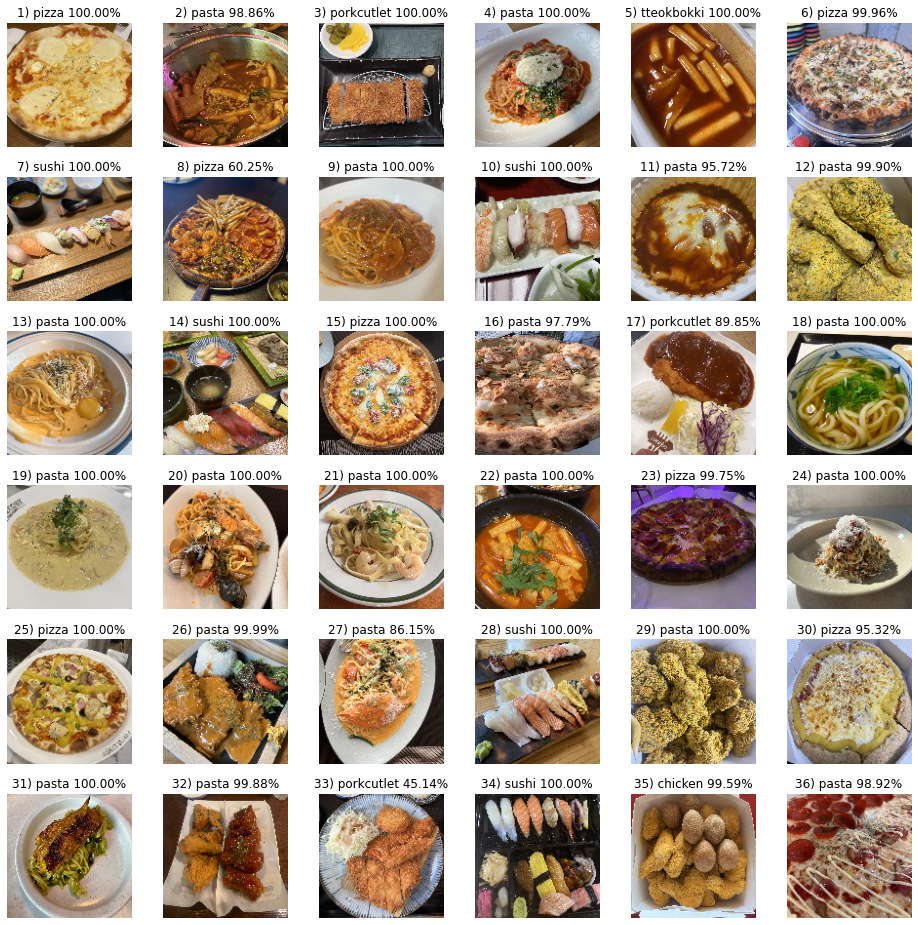

In [41]:
plt.figure(figsize=(13,13))

for i in range(len(pred)):
    plt.subplot(round(len(pred)/6), 6, i+1)
    class_index = np.argmax(pred[i])
    strTitle = str('{0:0.2f}'.format(100*max(pred[i]))) + '%'
    plt.title(str(i+1) + ') ' + class_name[class_index] + ' ' + strTitle) 
    plt.imshow(pred_img_list[i])
    plt.axis('off')
plt.tight_layout()